In [1]:
import tensorflow as tf
import numpy as np

print("TensorFlow version: ", tf.__version__)

2025-04-27 17:24:56.415193: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 17:24:56.657434: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 17:24:56.869870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745749497.059289   11711 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745749497.107319   11711 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745749497.484185   11711 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

TensorFlow version:  2.19.0


In [2]:
# Load dữ liệu CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0



In [ ]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# Dữ liệu giả
x_train = np.random.randn(100, 32, 32, 3).astype(np.float32)
y_train = np.random.randint(0, 10, size=(100,))

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

# Định nghĩa model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', use_bias=False, name='conv1', input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), name='pool1'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', use_bias=False, name='conv2', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), name='pool2'),
    tf.keras.layers.Flatten(name='flatten'),
    tf.keras.layers.Dense(64, activation='relu', use_bias=False, name='dense1'),
    tf.keras.layers.Dense(10, activation='softmax', use_bias=False, name='output')
])

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

num_epochs = 1

# Warmup model
_ = model(np.zeros((1, 32, 32, 3), dtype=np.float32))

# In tên và shape của các biến trainable
print("Trainable variables:")
for var in model.trainable_variables:
    print(f"Variable name: {var.name}, Shape: {var.shape}")

# Ghi log gradient
with open('log.txt', 'w') as log_file:
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch}")
        for i, (x, y) in enumerate(tqdm(train_dataset)):
            with tf.GradientTape() as tape:
                logits = model(x, training=True)
                loss = loss_fn(y, logits)

                # Kiểm tra conv1 output
                conv1_model = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer('conv1').output)
                conv1_act = conv1_model(x, training=True)
                max_act = tf.reduce_max(conv1_act).numpy()
                min_act = tf.reduce_min(conv1_act).numpy()
                non_zero_count = tf.reduce_sum(tf.cast(conv1_act != 0, tf.float32)).numpy()
                total_count = tf.size(conv1_act).numpy()
                print(f"Epoch {epoch}, Image {i}: conv1 output max={max_act:.6f}, min={min_act:.6f}, non-zero: {non_zero_count}/{total_count}")

                if max_act == 0 and min_act == 0:
                    print(f"Warning: conv1 output toàn 0 tại image {i}, epoch {epoch}")

            # Tính gradient
            grads = tape.gradient(loss, model.trainable_variables)

            # Kiểm tra tất cả gradient
            print(f"Gradients for image {i}:")
            for var, grad in zip(model.trainable_variables, grads):
                print(f"Variable: {var.name}, Shape: {var.shape}, Gradient exists: {grad is not None}")

            # Tìm gradient của conv1/kernel
            found = False
            for var, grad in zip(model.trainable_variables, grads):
                # Kiểm tra dựa trên tên hoặc shape (3, 3, 3, 32) cho conv1
                if 'conv1' in var.name.lower() or var.shape == (3, 3, 3, 32):
                    found = True
                    if grad is None:
                        print(f"Warning: Gradient của {var.name} là None tại image {i}, epoch {epoch}")
                        log_file.write(f"Epoch {epoch}, Image {i}: Gradient None for {var.name}\n")
                    else:
                        grad_np = grad.numpy().flatten()
                        grad_list = grad_np.tolist()
                        log_file.write(f"Epoch {epoch}, Image {i}, Layer {var.name}:\n")
                        log_file.write(f"Gradient shape: {grad.numpy().shape}\n")
                        log_file.write(f"Gradient values: {grad_list}\n")
                        log_file.write(f"Gradient mean: {np.mean(grad_np):.6f}, max: {np.max(grad_np):.6f}, min: {np.min(grad_np):.6f}\n")
                        log_file.write("-" * 50 + "\n")
                        log_file.flush()
                    break

            if not found:
                print(f"Warning: Không tìm thấy conv1/kernel gradient tại image {i}, epoch {epoch}")
                log_file.write(f"Epoch {epoch}, Image {i}: conv1/kernel not found\n")
                log_file.flush()

            # Áp dụng gradient
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [4]:
# Compile và train
model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 16, 16, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,080 (1.08 MB)

 Trainable params: 282,080 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.fit(x_train, y_train, epochs=5, validation_split = 0.2)

Epoch 1/5


2025-04-27 15:28:05.899539: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 491520000 exceeds 10% of free system memory.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2094 - loss: 2.1523

2025-04-27 15:28:59.215760: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 57s 45ms/step - accuracy: 0.2094 - loss: 2.1522 - val_accuracy: 0.3666 - val_loss: 1.7907
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.3915 - loss: 1.7137 - val_accuracy: 0.4425 - val_loss: 1.5791
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.4642 - loss: 1.4971 - val_accuracy: 0.4938 - val_loss: 1.4238
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.5066 - loss: 1.3949 - val_accuracy: 0.5353 - val_loss: 1.3214
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 69s 55ms/step - accuracy: 0.5476 - loss: 1.2890 - val_accuracy: 0.5507 - val_loss: 1.2824


In [6]:
# Sau khi train xong, đánh giá trên test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

  9/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5309 - loss: 1.2467

2025-04-27 15:33:20.404373: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5525 - loss: 1.2604
Test accuracy: 0.5538


In [27]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [input_value]

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

In [29]:
tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpq322c9sq/assets


INFO:tensorflow:Assets written to: /tmp/tmpq322c9sq/assets
/home/tuananh/.local/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-04 15:36:31.741351: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-04 15:36:31.741372: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-04 15:36:31.741509: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq322c9sq
2025-04-04 15:36:31.742371: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-04 15:36:31.742383: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpq322c9sq
2025-04-04 15:36:31.744459: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04-04 15:36:31.76

In [30]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [33]:
import pathlib

tflite_models_dir = pathlib.Path("./cifar_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"cifar_model.tflite"
# tflite_model_file.write_bytes(tflite_model_quant)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"cifar_model_quant.tflite"
# tflite_model_quant_file.write_bytes(tflite_model_quant)

In [39]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global x_test

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = x_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [42]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global y_test

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(x_test[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(y_test[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

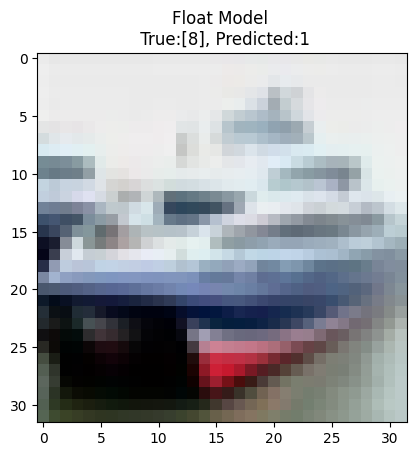

In [43]:
test_model(tflite_model_file, test_image_index, model_type="Float")

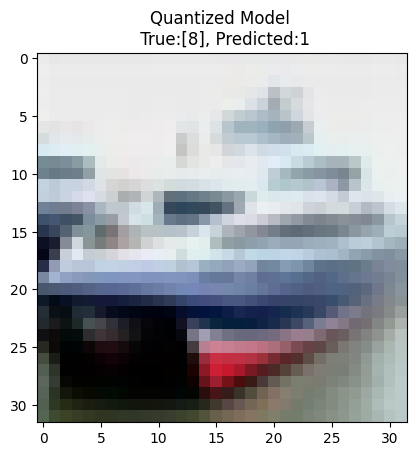

In [44]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

In [45]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global x_test
  global y_test

  test_image_indices = range(x_test.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(y_test== predictions) * 100) / len(x_test)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(x_test)))

In [46]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 100000.0000% (Number of test samples=10000)


In [47]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 100000.0000% (Number of test samples=10000)
